In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# BNN Modules
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from sklearn.model_selection import train_test_split

from pyro.infer import MCMC, NUTS

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ground_motion = pd.read_pickle("data/processed_ground_motion_PGA.pkl")
interest_index = (ground_motion['Earthquake Magnitude'] > 6.0) & (ground_motion['Earthquake Magnitude'] < 7.0)
ground_motion2 = ground_motion[interest_index]
Sample_Size = len(ground_motion2.index)
DNN_param = pickle.load(open('data/DNN_param.pkl', 'rb'))

In [3]:
def datasets_creation(NN=Sample_Size):
	X = np.zeros([NN,2])
	y = np.zeros(NN)
	y[:] = np.log(ground_motion2['PGA (g)'].values)
	X[:,0] = ground_motion2[['EpiD (km)']].values.T
	X[:,1] = ground_motion2[['Vs30 (m/s) selected for analysis']].values.T
	# We added shuffling to introduce stochasticity
	#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)
	X_train = torch.from_numpy(X).float()
	y_train = torch.from_numpy(y).float()
	return X_train, y_train


In [4]:
class Model01(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=300, prior_scale=10.):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, 1)
        self.layer3 = PyroModule[nn.Linear](200, 100)
        self.layer4 = PyroModule[nn.Linear](100, 50)
        self.layer5 = PyroModule[nn.Linear](50, 10)
        self.layer6 = PyroModule[nn.Linear](10, 10)
        self.layer7 = PyroModule[nn.Linear](10, 1)
        # Layer 01 R.V
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        # Layer 02 R.V
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))
        # Layer 03 R.V
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([100, 200]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([100]).to_event(1))
        # Layer 04 R.V
        self.layer4.weight = PyroSample(dist.Normal(0., prior_scale).expand([50, 100]).to_event(2))
        self.layer4.bias = PyroSample(dist.Normal(0., prior_scale).expand([50]).to_event(1))
        # Layer 05 R.V
        self.layer5.weight = PyroSample(dist.Normal(0., prior_scale).expand([10, 50]).to_event(2))
        self.layer5.bias = PyroSample(dist.Normal(0., prior_scale).expand([10]).to_event(1))
        # Layer 06 R.V
        self.layer6.weight = PyroSample(dist.Normal(0., prior_scale).expand([10, 10]).to_event(2))
        self.layer6.bias = PyroSample(dist.Normal(0., prior_scale).expand([10]).to_event(1))
        # Layer 07 R.V
        self.layer7.weight = PyroSample(dist.Normal(0., prior_scale).expand([1, 10]).to_event(2))
        self.layer7.bias = PyroSample(dist.Normal(0., prior_scale).expand([1]).to_event(1))


    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
#        x = self.activation(self.layer2(x))
#        x = self.activation(self.layer3(x))
#        x = self.activation(self.layer4(x))
#        x = self.activation(self.layer5(x))
#        x = self.activation(self.layer6(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [5]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)
    y_pred = np.exp(y_pred)
    ax.semilogx(10**np.linspace(0,2.5,101), y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

In [6]:
X_train, y_train = datasets_creation()
model = Model01()
pyro.set_rng_seed(42)
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=100)
mcmc.run(X_train, y_train)
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 100
X_trial = torch.tensor(X_trial, dtype=torch.float32)
preds = predictive(X_trial)

Sample: 100%|████████████████████████████████████████| 200/200 [2:12:51, 39.86s/it, step size=1.42e-04, acc. prob=0.909]                     


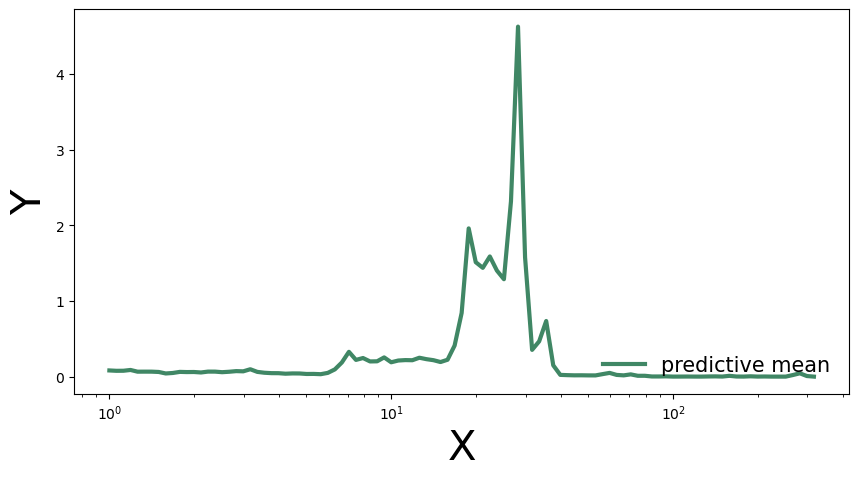

In [7]:
plot_predictions(preds)

In [8]:
preds

{'obs': tensor([[ -1.9421,  -1.0862,  -1.3283,  ...,  -0.9846,  -8.2063, -23.5664],
         [ -2.0626,  -3.3476,  -0.9473,  ...,  -4.6105,  -8.5411, -23.3734],
         [ -2.4315,  -3.3462,  -5.1690,  ...,  -1.7088,  -7.0354, -22.2274],
         ...,
         [ -2.8861,  -0.7627,  -3.6721,  ...,  -4.0475,  -3.8515, -17.0037],
         [ -3.7651,  -2.4953,  -0.8941,  ...,  -2.9963,  -5.8979, -18.8872],
         [ -1.8499,  -2.4225,  -1.6674,  ...,  -4.9027,  -2.6395, -19.8291]])}